In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [311]:
N = 101
x = np.sort(np.random.uniform(0, 10, N))
tau = x[:, None] - x[None, :]
K = np.exp(-0.5 * tau**2) * np.cos(2*np.pi*np.abs(tau))
K[np.diag_indices_from(K)] += 0.1
# K = K[:N//2, N//2:]

In [312]:
def low_rank_approx(K,
                    start_row=0, n_rows=None,
                    start_col=0, n_cols=None,
                    tol=1.234e-5, max_rank=None, seed=None):
    rng = np.random.RandomState(seed)
    
    n_rows = K.shape[0] - start_row if n_rows is None else n_rows
    n_cols = K.shape[1] - start_col if n_cols is None else n_cols
    if max_rank is None:
        max_rank = min(n_rows, n_cols)
    U = np.empty((n_rows, max_rank))
    V = np.empty((n_cols, max_rank))

    rank = 0
    index = np.arange(n_rows)
    norm = 0.0
    finished = False
    rows = slice(start_row, start_row+n_rows)
    cols = slice(start_col, start_col+n_cols)
    
    while True:
        while True:
            if not len(index):
                finished = True
                break
            k = rng.randint(len(index))
            i = index[k]
            index[k] = index[-1]
            index = index[:-1]
            
            row = (K[start_row+i, cols] -
                   np.dot(U[i, :rank], V[:, :rank].T))
            j = np.argmax(np.abs(row))
            if np.abs(row[j]) > 1e-14:
                break
                        
        if finished:
            if not rank:
                print("failed")
                if n_cols <= n_rows:
                    return K[rows, cols], np.eye(n_cols)
                return np.eye(n_rows), K[rows, cols].T
            break
        
        row /= row[j]
        V[:, rank] = row
        
        U[:, rank] = col = (K[rows, start_col+j] -
                            np.dot(U[:, :rank], V[j, :rank]))
        
        rank += 1
        if rank >= max_rank:
            break
    
        rowcol_norm = np.dot(row, row) * np.dot(col, col)
        if rowcol_norm < tol**2 * norm:
            break
        
        norm += rowcol_norm
        s = np.dot(U[:, :rank-1].T, col)
        norm += 2 * np.sum(np.abs(s))
        s = np.dot(V[:, :rank-1].T, row)
        norm += 2 * np.sum(np.abs(s))
    
    return U[:, :rank], V[:, :rank]

U, V = low_rank_approx(K, N//2, N-N//2, 0, N//2, seed=42)

In [313]:
U.shape, V.shape, K[N//2:, :N//2].shape

((51, 18), (50, 18), (51, 50))

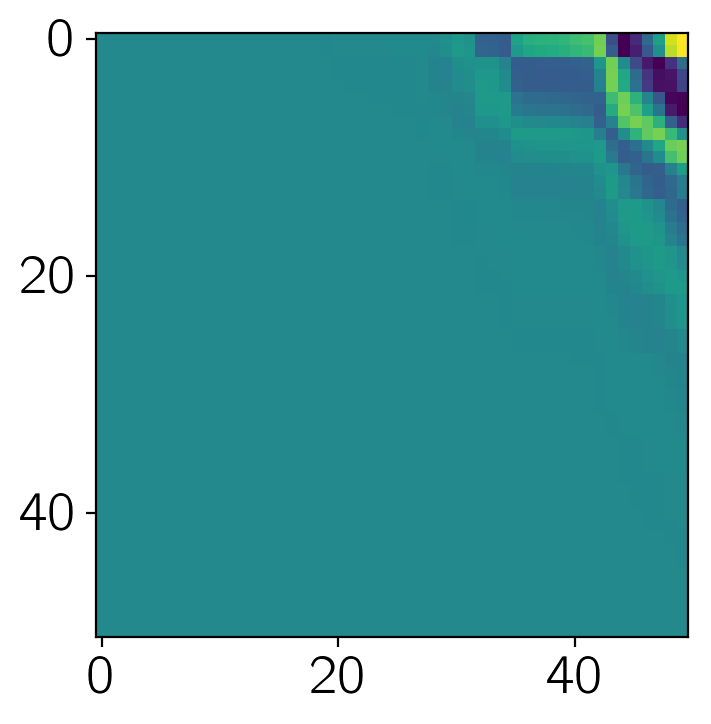

In [314]:
plt.imshow(K[N//2:, :N//2], interpolation="nearest")

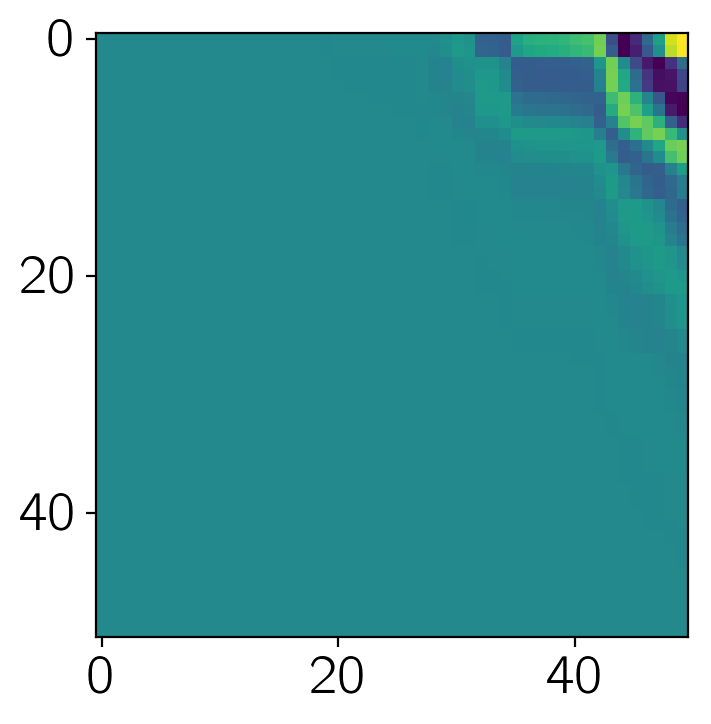

In [315]:
plt.imshow(np.dot(U, V.T), interpolation="nearest")

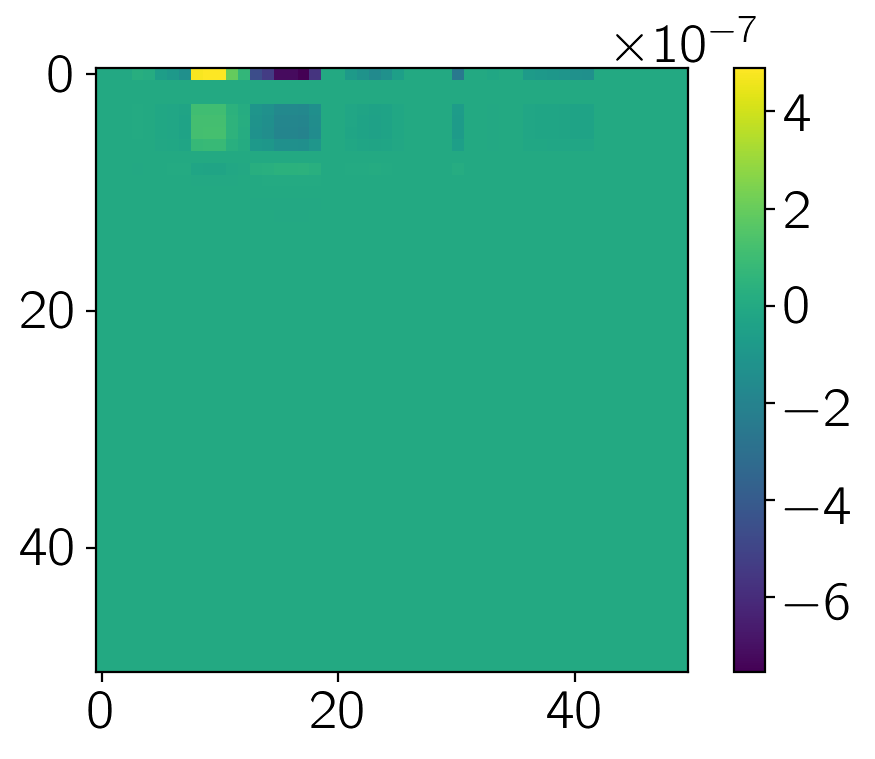

In [316]:
plt.imshow((K[N//2:, :N//2] - np.dot(U, V.T)), interpolation="nearest")
plt.colorbar()

In [339]:
from scipy.linalg import lu_factor, lu_solve

class Node(object):
    
    def __init__(self, K,
                 start=0, size=None,
                 tol=1.234e-5, min_size=100,
                 seed=None):
        size = K.shape[0] if size is None else size
        self.start = start
        self.size = size
        if size > min_size:
            self.U, self.V = low_rank_approx(
                K,
                start_row=start+size//2,
                n_rows=size-size//2,
                start_col=start,
                n_cols=size//2,
                tol=tol, seed=seed)
            
            rank = self.V.shape[1]
            self.K = np.eye(2*rank)
            self.K[:rank, rank:] = np.dot(self.U.T, self.U)
            self.K[rank:, :rank] = np.dot(self.V.T, self.V)

            self.is_leaf = False
            self.children = [
                Node(K, start, size//2,
                     tol, min_size),
                Node(K, start+size//2, size-size//2,
                     tol, min_size),
            ]
            
        else:
            self.is_leaf = True
            self.children = []
            # Don't forget the diagonal
            self.K = np.array(K[start:start+size, start:start+size])
        
        self.K = lu_factor(self.K, overwrite_a=True)
    
    def __repr__(self):
        return ("Node({0.start_row}, {0.n_rows}, "
                "{0.start_col}, {0.n_cols})").format(self)
    
    def apply_inverse(self, x, start):
        if self.is_leaf:
            start = self.start - start
            x[start:start+self.size] = lu_solve(self.K, x[start:start+self.size])
            
    def log_determinant(self):
        logdet = np.sum(np.log(np.abs(np.diag(self.K[0]))))
        for child in self.children:
            logdet += child.log_determinant()
        return logdet

In [340]:
root = Node(K, seed=42, min_size=10)

In [341]:
root.log_determinant()

-55.185118321296407

In [342]:
np.linalg.slogdet(K)

(1.0, -163.67731577167658)

In [304]:
x = np.random.randn(N, 5)
x0 = np.array(x)

In [305]:
root.children[0].children[0].children[0].children[0].apply_inverse(x, 0)

In [306]:
x - x0

array([[ -0.03923113,  -8.36562445,  10.2144537 ,   1.10624199,
         -3.27041698],
       [ -0.40610951,   6.15431081, -14.77046646,  -2.65001003,
          3.97901915],
       [ 11.52845775,  -2.01248032,  10.26827782,   8.07112127,
          4.88649793],
       [ -3.99225822,  10.96376208,   0.8075978 ,  -0.2798934 ,
          0.45895297],
       [ -8.13491143,  -6.78481199,  -1.50975917,  -5.71341169,
         -6.25646171],
       [  0.17170966,  -3.65209488,  -0.99685414,  -0.20744147,
          0.11579928],
       [  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
    

In [331]:
np.sum(np.log(np.abs(np.diag(lu_factor(K)[0]))))

-163.67731577167658

In [332]:
np.linalg.slogdet(K)

(1.0, -163.67731577167658)